# Data taken from UCI ML Repository
https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength



In [ ]:
"""
Abstract: Concrete is the most important material in civil engineering. The
concrete compressive strength is a highly nonlinear function of age and
ingredients. These ingredients include cement, blast furnace slag, fly ash,
water, superplasticizer, coarse aggregate, and fine aggregate.

Data Characteristics:

The actual concrete compressive strength (MPa) for a given mixture under a
specific age (days) was determined from laboratory. Data is in raw form (not scaled).

Summary Statistics:

Number of instances (observations): 1030
Number of Attributes: 9
Attribute breakdown: 8 quantitative input variables, and 1 quantitative output variable
Missing Attribute Values: None

"""

In [89]:
"""
Business Goal: To find whihc variable plays an important role Concrete Compressive Strength

Metrics - RMS and R2 Square

I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial
neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998).
"""

'\nBusiness Goal: To find whihc variable plays an important role Concrete Compressive Strength\n\nMetrics - RMS and R2 Square\n\nI-Cheng Yeh, "Modeling of strength of high performance concrete using artificial\nneural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998).\n'

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, SCORERS
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, 
                              AdaBoostRegressor, 
                              GradientBoostingRegressor)
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
import tensorflow  as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras import backend


In [2]:
# Read dataset
data_folder = Path('/content/drive/My Drive/Data_Science/Kaggle/Compressive Concrete Strength')

data_orig = pd.read_excel( data_folder / 'Concrete_Data.xls')

In [3]:
data_orig.shape

(1030, 9)

In [4]:
df = data_orig.copy()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement (component 1)(kg in a m^3 mixture),1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
Blast Furnace Slag (component 2)(kg in a m^3 mixture),1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
Fly Ash (component 3)(kg in a m^3 mixture),1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
Water (component 4)(kg in a m^3 mixture),1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
Superplasticizer (component 5)(kg in a m^3 mixture),1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
Coarse Aggregate (component 6)(kg in a m^3 mixture),1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
Fine Aggregate (component 7)(kg in a m^3 mixture),1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
Age (day),1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
"Concrete compressive strength(MPa, megapascals)",1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


In [5]:
col_names =  ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 
             'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate',  
             'Age','Concrete compressive strength']

In [6]:
type(col_names)

list

In [7]:
df.set_axis([col_names], axis = 'columns', inplace = True)

In [8]:
df.head().T

,0,1,2,3,4
Cement,540.000000,540.000000,332.500000,332.50000,198.600000
Blast Furnace Slag,0.000000,0.000000,142.500000,142.50000,132.400000
Fly Ash,0.000000,0.000000,0.000000,0.00000,0.000000
Water,162.000000,162.000000,228.000000,228.00000,192.000000
Superplasticizer,2.500000,2.500000,0.000000,0.00000,0.000000
Coarse Aggregate,1040.000000,1055.000000,932.000000,932.00000,978.400000
Fine Aggregate,676.000000,676.000000,594.000000,594.00000,825.500000
Age,28.000000,28.000000,270.000000,365.00000,360.000000
Concrete compressive strength,79.986111,61.887366,40.269535,41.05278,44.296075


In [ ]:
df.head()

In [9]:
# checking if there any null values in dataset
df.isnull().sum()

Cement                           0
Blast Furnace Slag               0
Fly Ash                          0
Water                            0
Superplasticizer                 0
Coarse Aggregate                 0
Fine Aggregate                   0
Age                              0
Concrete compressive strength    0
dtype: int64

# EDA

In [ ]:
df.head()

In [10]:
# Splitting the dataset for train, val, and test

X_train, X_test, y_train, y_test = train_test_split(
          df[df.columns[:-1]],
         df[df.columns[-1]],
         test_size = 0.2, random_state = 42)

# X_train, X_val, y_train, y_val = train_test_split(
#           X_train1[X_train1.columns[:-1]],
#          X_train1[X_train1.columns[-1]],
#          test_size = 0.2, random_state = 42)



# X_train_min = X_train.min()
# X_train_max = X_train.max()

# X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
# # X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
# X_test = (X_test - X_train_min) / (X_train_max - X_train_min)



In [ ]:
type(X_train)

In [ ]:
scatter_matrix = scatter_matrix(X_train, figsize = (15,15), diagonal = 'kde')

No correlation between any of the features

In [ ]:
sns.heatmap(X_train.corr(), annot = True, cmap = 'Blues')
# Negative correlation(-0.65) between Water and Superplasticizer.

# Linear Regression

In [11]:
# Saving model perfromance metrics in list

model_list = []
rmse_list = []
r2_list = []
cv = KFold(5, random_state = 42)

# applying column standardization
# to avoid data leakage using X_train's mean and std dev for val/test

scaler1, scaler2 = StandardScaler(), StandardScaler()
X_train = scaler1.fit_transform(X_train)
X_test = scaler2.fit_transform(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
# Linear Regression

lr_rmse = np.sqrt((-1) * cross_val_score(LinearRegression(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

lr_r2 = cross_val_score(LinearRegression(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()

print( lr_rmse)
print(lr_r2)

# Ridge Regression (L2 Penalty)

In [ ]:
ridge_rmse = np.sqrt((-1) * cross_val_score(Ridge(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

ridge_r2 = cross_val_score(Ridge(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()


print(ridge_rmse) 
print(ridge_r2)                      

# Lasso Regression(L1 Penalty)

In [ ]:
lasso_rmse = np.sqrt((-1) * cross_val_score(Lasso(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

lasso_r2 = cross_val_score(Lasso(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()

print(lasso_rmse)
print(lasso_r2)

# K Neighbors Regressor

In [ ]:
knn_rmse = np.sqrt((-1) * cross_val_score(KNeighborsRegressor(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

knn_r2 = cross_val_score(KNeighborsRegressor(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()

print(knn_rmse)
print(knn_r2)

# Decision Tree Regressor

In [ ]:
dt_rmse = np.sqrt((-1) * cross_val_score(DecisionTreeRegressor(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

dt_r2 = cross_val_score(DecisionTreeRegressor(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()
print(dt_rmse)
print(dt_r2)

# Random Forest Regressor

In [ ]:
rf_rmse = np.sqrt((-1) * cross_val_score(RandomForestRegressor(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

rf_r2 = cross_val_score(RandomForestRegressor(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()
print(rf_rmse)
print(rf_r2)

# Gradient Boosting Regressor

In [ ]:
gb_rmse = np.sqrt((-1) * cross_val_score(GradientBoostingRegressor(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

gb_r2 = cross_val_score(GradientBoostingRegressor(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()
print(gb_rmse)
print(gb_r2)

# Adaboost Regressor

In [ ]:
ada_rmse = np.sqrt((-1) * cross_val_score(AdaBoostRegressor(), 
                X_train, y_train, cv=cv, 
                scoring = 'neg_mean_squared_error').mean())

ada_r2 = cross_val_score(AdaBoostRegressor(),
                        X_train, y_train, cv = cv,
                        scoring = 'r2').mean()
print(ada_rmse)
print(ada_r2)

It looks like Gadient Boosting gives best result. Let's tune the hyperparameters

In [ ]:

grid_param = {'n_estimators': range(100, 501, 50),
              'max_depth': range(5, 21, 5),
              'min_samples_split': range(200, 1001, 200),
              'learning_rate': [0.3]} #range(0.2, 0.8, 0.1)}
grid_rgr = GridSearchCV(GradientBoostingRegressor(random_state = 42), 
                        param_grid = grid_param,
                        scoring = 'r2', cv =cv)
grid_rgr.fit(X_train, y_train)

In [ ]:
print(grid_rgr.best_estimator_)
print('R Sqaured is :', grid_rgr.best_score_)

R2 of 0.93 is the best so far.

#Compare Test dataset

In [ ]:
clf_te = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=200,
                          min_weight_fraction_leaf=0.0, n_estimators=350,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
clf_te.fit(X_train, y_train)

print('RMSE for test is ', np.sqrt(mean_squared_error(y_test,
                                                          clf_te.predict(X_test))))
print('R2 is', r2_score(y_test, clf_te.predict(X_test)))

# gb_rmse = np.sqrt((-1) * cross_val_score(GradientBoostingRegressor(), 
#                 X_train, y_train, cv=cv, 
#                 scoring = 'neg_mean_squared_error').mean())

# gb_r2 = cross_val_score(GradientBoostingRegressor(),
#                         X_train, y_train, cv = cv,
#                         scoring = 'r2').mean()

# Neural Network

In [ ]:
#https://www.tensorflow.org/tutorials/keras/regression

In [54]:
#https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_true - y_pred), axis=-1))

def r2_square(y_true, y_pred):
    SS_res = backend.sum(backend.square(y_true - y_pred))
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true)))
    return (1 - SS_res/(SS_tot + backend.epsilon())) # epsilon to avoid divide by zero

def my_nn_model(input):
  
  model = keras.Sequential([
                  keras.layers.Input(shape = (input )),#, name = ' input_layer'),
                  keras.layers.Dense(10, activation = 'relu'),#,kernel_regularizer=l2(0.0001),name = 'layer1'),
                #   keras.layers.Dropout(0.1),                  
                  keras.layers.Dense(5, activation = 'relu'),#'relu',name = 'layer2'),
                #   keras.layers.Dropout(0.1),
                  keras.layers.Dense(1, #activation = 'relu', 
                                      name = 'final_layer')

                           ])
  model.compile( optimizer = tf.keras.optimizers.Adam(lr = 0.005, decay = 0.0000001),
                loss = tf.keras.losses.mean_squared_error,
                # metrics  = [rmse]#, tf.keras.metrics.RSquare()]
                metrics  = [ rmse, r2_square]
                )
  return model

In [55]:
tf.keras.backend.clear_session() # initialize the model

model_nn = my_nn_model(X_train.shape[1])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
final_layer (Dense)          (None, 1)                 6         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [72]:
%%time

EPOCHS = 100
BATCH_SIZE = 32

history_nn = model_nn.fit(
    X_train, y_train, batch_size = BATCH_SIZE,
    validation_split = 0.2,
    epochs = EPOCHS, verbose=0
)



CPU times: user 3.9 s, sys: 251 ms, total: 4.16 s
Wall time: 3.36 s


In [73]:
# convert history to dataframe
history_nn_df = pd.DataFrame(history_nn.history)
history_nn_df.head()

,loss,rmse,r2_square,val_loss,val_rmse,val_r2_square
0,40.343842,4.939168,0.849932,40.550392,4.825109,0.775898
1,40.435600,4.972395,0.849623,40.208279,4.805691,0.779612
2,39.730812,4.912615,0.856237,43.630234,5.000253,0.771590
3,41.412888,5.012877,0.849117,40.056080,4.820477,0.782119
4,39.726139,4.868172,0.856157,38.689617,4.826909,0.782531


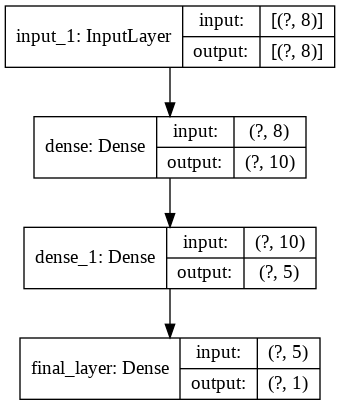

In [62]:
plot_model(model_nn, show_shapes = True)

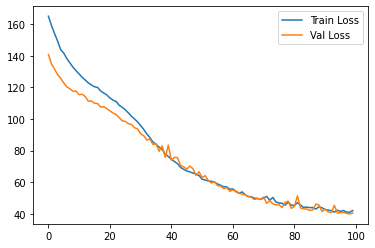

In [63]:
# plot losses
plt.plot(history_nn.epoch, history_nn.history['loss'], label = 'Train Loss')
plt.plot(history_nn.epoch, history_nn.history['val_loss'], label = 'Val Loss')
plt.legend()
plt.show()

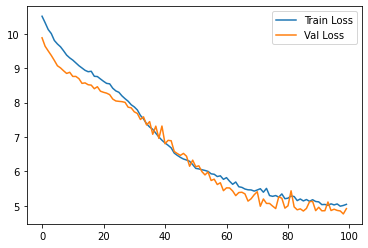

In [64]:
# plot RMSE

plt.plot(history_nn.epoch, history_nn.history['rmse'], label = 'Train Loss')
plt.plot(history_nn.epoch, history_nn.history['val_rmse'], label = 'Val Loss')
plt.legend()
plt.show()

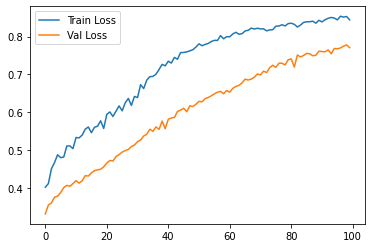

In [65]:
# plot RMSE

plt.plot(history_nn.epoch, history_nn.history['r2_square'], label = 'Train Loss')
plt.plot(history_nn.epoch, history_nn.history['val_r2_square'], label = 'Val Loss')
plt.legend()
plt.show()

In [75]:
print(history_nn.history)
print('Train loss is ',history_nn.history['loss'][-1])
print('Train rmse is ',history_nn.history['rmse'][-1])
print('Train r2_square is ',history_nn.history['r2_square'][-1])

{'loss': [40.343841552734375, 40.43560028076172, 39.730812072753906, 41.41288757324219, 39.726139068603516, 40.58024978637695, 39.684566497802734, 39.044925689697266, 39.74472427368164, 39.19728469848633, 40.65967559814453, 39.622337341308594, 38.507659912109375, 38.39431381225586, 38.79970169067383, 38.79266357421875, 39.226318359375, 39.69071960449219, 37.9091911315918, 38.13937759399414, 40.01068878173828, 37.950836181640625, 39.552146911621094, 40.407291412353516, 37.895599365234375, 38.119998931884766, 37.78499221801758, 37.216068267822266, 37.9248046875, 37.524837493896484, 38.37629318237305, 38.02090835571289, 39.31897735595703, 37.78262710571289, 37.12184524536133, 38.13865280151367, 38.126853942871094, 37.44725799560547, 37.30007553100586, 37.73938751220703, 37.937782287597656, 37.00843048095703, 37.270240783691406, 36.535972595214844, 37.55967330932617, 37.11656188964844, 36.34696960449219, 37.99931716918945, 38.09846115112305, 37.59534454345703, 35.9235954284668, 36.27840042

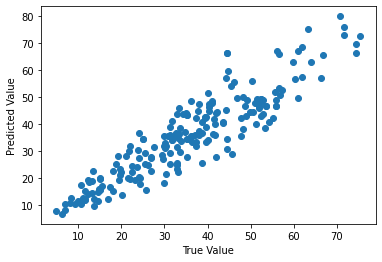

Test rmse is  tf.Tensor(6.675045355729984, shape=(), dtype=float64)
Test r2_square is  tf.Tensor(0.8270877, shape=(), dtype=float32)


In [99]:
#https://www.tensorflow.org/tutorials/keras/regression
# test prediction

test_pred = model_nn.predict(X_test).flatten()

plt.scatter(y_test, test_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.show()
print('Test rmse is ',rmse(y_test, test_pred))
print('Test r2_square is ', r2_square(tf.convert_to_tensor(y_test, np.float32), test_pred))
